# Uncertainty estimation using ensembles of partly independent MLP models [plotting results based on simulations]

**Model description:**

-- Network outputs two values in the final layer, corresponding to the predicted **mean** and **variance** by treating the observed value as a sample from a Gaussian distribution

-- Ensemble members are trained on different bootstrap samples of the original training set; the mean and variance of a mixture are given by $$\mu_{*}(\mathbf{x})=M^{-1} \sum_{m} \mu_{\theta_{m}}(\mathbf{x}),$$  $$\sigma_{*}^{2}(\mathbf{x})=M^{-1} \sum_{m}\left(\sigma_{\theta_{m}}^{2}(\mathbf{x})+\mu_{\theta_{m}}^{2}(\mathbf{x})\right)-\mu_{*}^{2}(\mathbf{x}),$$ respectively.


In [1]:
import sys, os, glob
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
from astropy.io import fits
import numpy.ma as ma
from inverse_problem import SpectrumDataset, PregenSpectrumDataset, make_loader
from inverse_problem.nn_inversion.models_mlp import MlpPartlyIndepNet
from inverse_problem.nn_inversion.transforms import normalize_output
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params, plot_pred_vs_refer
from inverse_problem.nn_inversion import mlp_transform_rescale, normalize_spectrum
from inverse_problem.nn_inversion.posthoc import plot_fitting_curves_unc_double
from inverse_problem.nn_inversion.transforms import inverse_transformation_unc, inverse_transformation
from inverse_problem.nn_inversion.posthoc import plot_fitting_curves_unc
from inverse_problem.nn_inversion.posthoc import plot_params2

### Ensemble definition

In [4]:
ensemble_size = 6

### Data definition

Transformations: trigonometric transformation to the angle parameters and logarithmic one to the Field Strength vector

In [6]:
filename = '../data/parameters_base_new.fits'
transform = None
sobj = SpectrumDataset(param_path=filename, source='database', transform=transform)
sample = sobj[1]

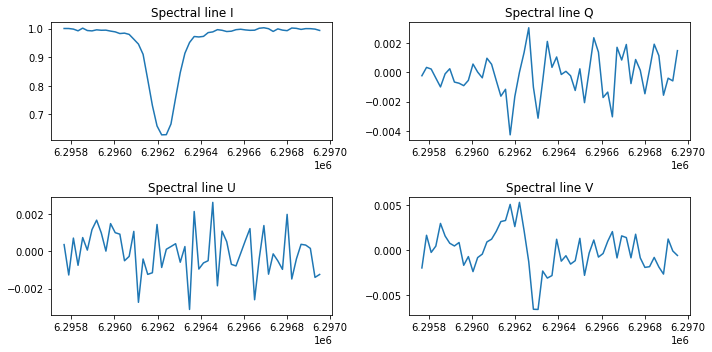

In [7]:
line_type = ['I','Q','U','V']
line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56)) - 6302.5
fig, ax = plt.subplots(2,2, figsize = (10,5))
for i in range(4):
    ax[i//2][i%2].plot(line_arg, sample['X'][0][:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
fig.set_tight_layout(tight = True)

In [12]:
params = fits.open(filename)[0].data
def params_masked_rows(pars_arr):
    max_par_values = np.array([par_arr.max() for par_arr in pars_arr.T])
    min_par_values = np.array([par_arr.min() for par_arr in pars_arr.T])
    bool_arr = (min_par_values + 1e-3 < pars_arr) & (pars_arr < max_par_values - 1e-3)
    return np.all(bool_arr, axis=1)


def create_masked_array(pars_arr):
    rows_mask = params_masked_rows(pars_arr)
    array_mask = rows_mask[:, np.newaxis] | np.zeros_like(pars_arr, dtype=bool)
    return ma.masked_array(pars_arr, mask=~array_mask)
rows_mask_params = params_masked_rows(params)
filtered_params = params[rows_mask_params, :]

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device.type)

cpu


In [13]:
factors, cont_scale = [1, 1000, 1000, 1000], 40000
angle_transformation, logB = True, True

transform_name = "conv1d_transform_rescale"

batch_size = 128
num_workers = 1 if 'cuda' in device.type else 0

In [14]:
train_loader, val_loader = make_loader(data_arr=filtered_params, transform_name=transform_name,
                                       factors=factors, cont_scale=cont_scale,
                                       logB=logB, angle_transformation=angle_transformation,
                                       batch_size=batch_size, num_workers=num_workers)

sample_batch = next(iter(train_loader))

print('Size of spectrum batch: ', sample_batch['X'][0].shape)
print('Size of cont batch: ', sample_batch['X'][1].shape)
print('Size of true params batch: ', sample_batch['Y'].shape)

print(f'\nNumber of batches for train: {len(train_loader)}, for validation: {len(val_loader)}')

Size of spectrum batch:  torch.Size([128, 4, 56])
Size of cont batch:  torch.Size([128, 1])
Size of true params batch:  torch.Size([128, 11])

Number of batches for train: 31243, for validation: 3472


### Define ensemble

`output_dim=22` for uncertainty estimation

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ensemble = [MlpPartlyIndepNet(input_dim=224, output_dim=22, hidden_dims=[200, 200, 200],
                              activation='elu', batch_norm=True, dropout=0.05, number_readout_layers=2).to(device) for _ in range(ensemble_size)]

### Load ensemble weights

In [15]:
save_path = '../unc_pred_ens_02-28_23-39/'
n_epochs = 4


for i, model in enumerate(ensemble):
    model.load_state_dict(torch.load(save_path + 'model_' + str(i) + '_ep' + str(n_epochs - 1) + '.pt', map_location=device)['model_state_dict'])

## Model analysis and data visualisation

Model analysis: how the network has learned to understand simulations and how the model is transfered into real data

Simulations are used for honest evaluation of architecture, spectral observations (Hinode, https://csac.hao.ucar.edu/fg_download.php) are used to adapt the model to real data

The preprocessing stage can be simplified with `PregenDataset`. The data can be also be prepared manually with `BatchMe`. Next, 500k parameters have to be loaded to make a simulation (and it works for a long time), in `SpectrumDataset` generation during training, so the parameters have to be only calculated and it is quite fast


In [16]:
path_to_refer = '../data/sp_20140926_170005/20140926_170005.fits'
data, names = open_param_file(path_to_refer, normalize=True, angle_transformation = angle_transformation, logB = logB)
print(data.shape)

Open file with 36 available parameters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Source_Function
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift
(512, 873, 11)


In [18]:
%%time
transform = mlp_transform_rescale(factors = factors, angle_transformation=angle_transformation,
                                  cont_scale=cont_scale, logB = logB)
test_dataset = PregenSpectrumDataset(param_path=path_to_refer, source='refer', transform=transform)


CPU times: user 31.3 s, sys: 18.2 s, total: 49.5 s
Wall time: 35.7 s


In [19]:
inputs = test_dataset.samples
sim_x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
y = inputs['Y'].to(device)

In [20]:
%%time

predicted_mean = np.zeros((ensemble_size, 446976, 11))
predicted_sigma = np.zeros((ensemble_size, 446976, 11))

for i, model in enumerate(ensemble):
    model.eval()
    with torch.no_grad():
        predicted = model(sim_x)
    predicted_mean[i] = predicted[:, :11].detach().cpu().numpy()
    predicted_sigma[i] = torch.exp(predicted[:, 11:]).detach().cpu().numpy()

CPU times: user 4min 35s, sys: 43.7 s, total: 5min 19s
Wall time: 3min 38s


In [21]:
refer_unnormalized, names = open_param_file(path_to_refer, normalize=False)
ref_unnormalized_2d = refer_unnormalized.reshape(-1, 11)
refer_shape = refer_unnormalized.shape
print('\n', refer_shape)

Open file with 36 available parameters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Source_Function
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift

 (512, 873, 11)


In [22]:
ref_2d = normalize_output(ref_unnormalized_2d.copy(),
                          logB=logB,
                          angle_transformation=angle_transformation)
refer = ref_2d.reshape(refer_shape).copy()

In [23]:
masked_ref_2d = create_masked_array(ref_2d)
masked_ref = masked_ref_2d.reshape(refer.shape)
masked_ref_unnormalized_2d = create_masked_array(ref_unnormalized_2d)
masked_ref_unnormalized = masked_ref_unnormalized_2d.reshape(refer.shape)

In [77]:
compute_metrics(refer, predicted_mean[1],
                sigmas=predicted_sigma[1], save_path=save_path + 'metrics_single_model.csv')

,r2,mse,mae,nlpd,nrmse,picp68,picp95
Field Strength,0.9143,0.0015,0.0191,-2.7353,0.9765,0.7924,0.9588
Field Inclination,0.9522,0.0034,0.0246,-2.3562,1.0789,0.8083,0.9590
Field Azimuth,0.7345,0.0313,0.0929,-1.3560,0.7205,0.8664,0.9822
Doppler Width,0.9702,0.0005,0.0150,-2.6756,0.8737,0.7561,0.9769
Damping,0.9342,0.0015,0.0188,-2.6581,0.8687,0.7699,0.9741
Line Strength,0.8209,0.0025,0.0187,-2.7896,0.9134,0.7947,0.9678
S_0,0.9032,0.0005,0.0134,-2.7694,0.8475,0.7809,0.9784
S_1,0.9810,0.0002,0.0086,-3.1953,0.8194,0.7971,0.9815
Doppler Shift,0.9560,0.0001,0.0043,-4.2196,0.7790,0.8200,0.9844
Filling Factor,0.8588,0.0096,0.0618,-1.3450,0.9635,0.7545,0.9540


In [25]:
inv_angle_transformation = angle_transformation

In [26]:
predicted_mean_norm = predicted_mean.copy()
predicted_sigma_norm = predicted_sigma.copy()

predicted_mean_norm[0], predicted_sigma_norm[0] = inverse_transformation_unc(predicted_mean[0], predicted_sigma[0], inv_angle_transformation=False)
true = inverse_transformation(masked_ref_2d.data, inv_angle_transformation=inv_angle_transformation)

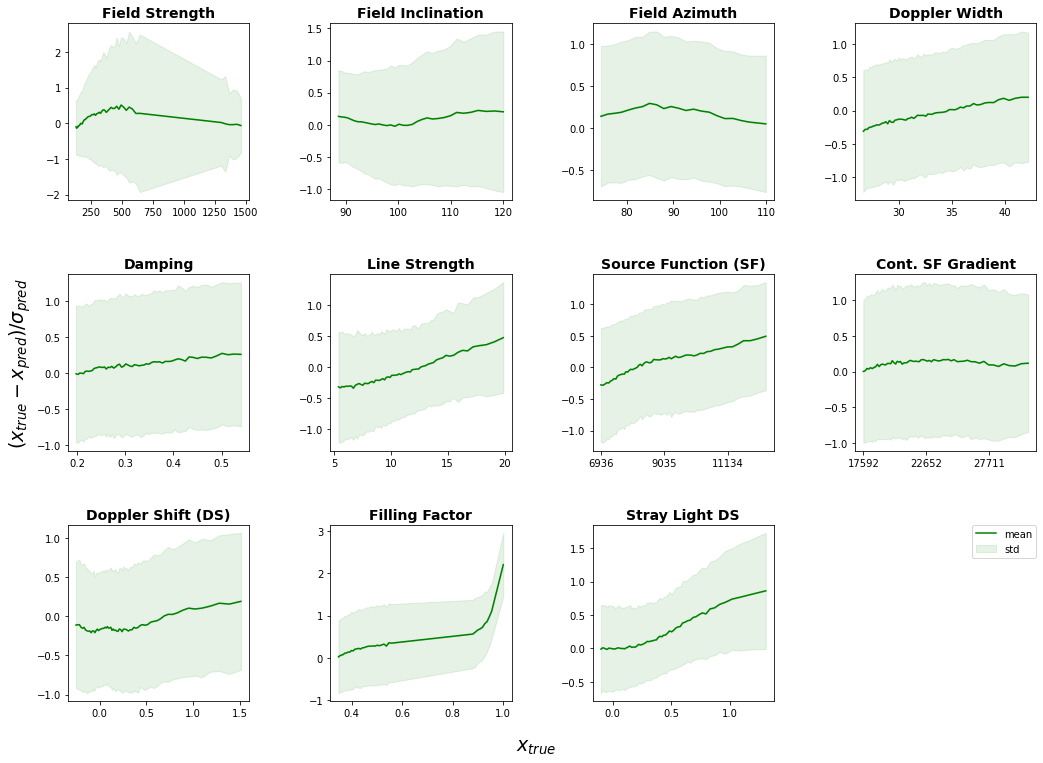

In [41]:
from inverse_problem.nn_inversion.posthoc import plot_fitting_curves_unc
plot_fitting_curves_unc(true, predicted_mean_norm[0], predicted_sigma_norm[0], save_path=save_path, title='refer_one_model')

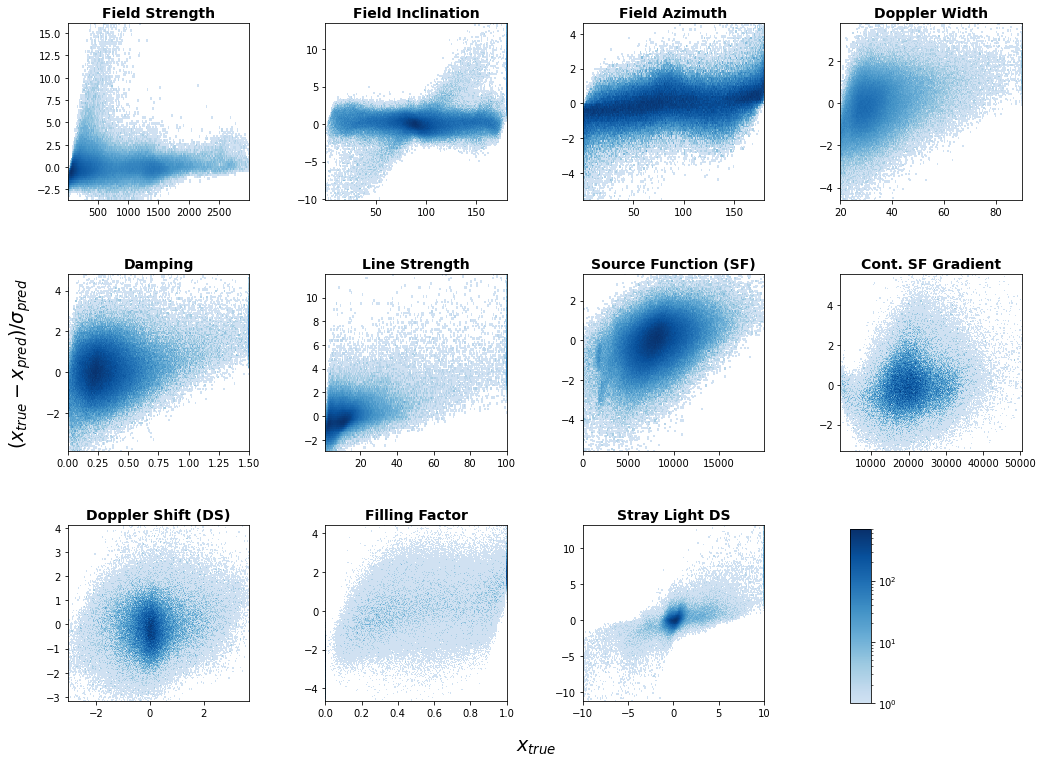

In [33]:
from inverse_problem.nn_inversion.posthoc import plot_analysis_hist2d_unc
plot_analysis_hist2d_unc(true, predicted_mean_norm[0], predicted_sigma_norm[0], index=0, bins=300, save_path=save_path, title='refer_one_model');

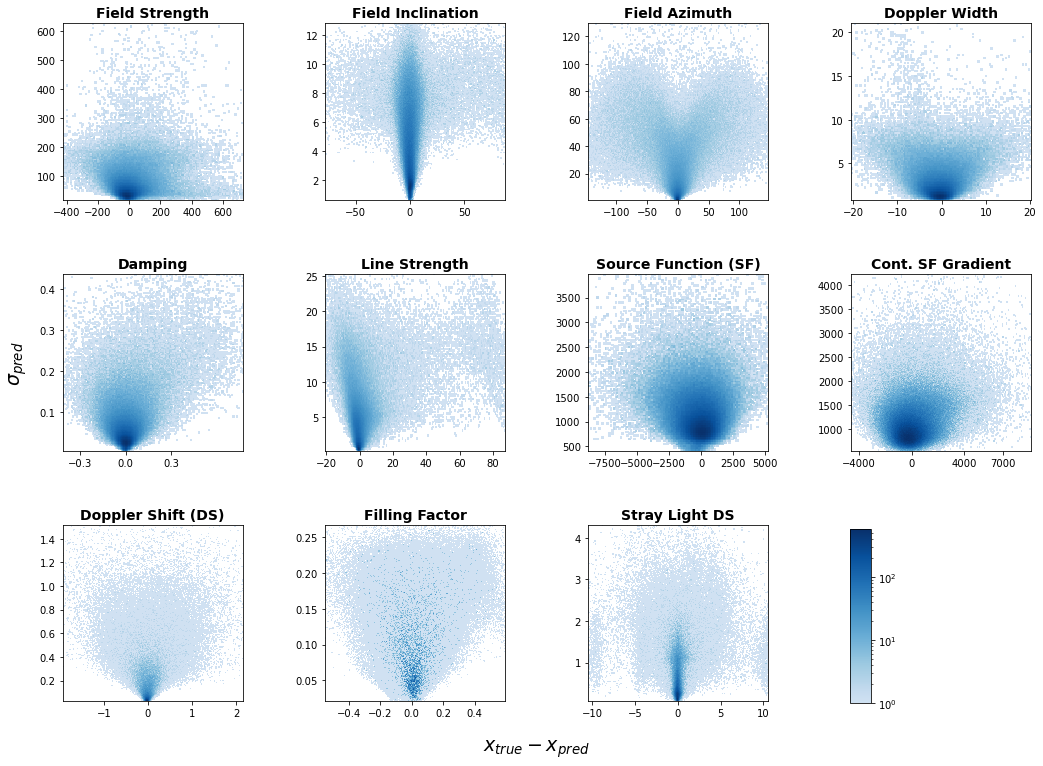

In [53]:
from inverse_problem.nn_inversion.posthoc import plot_analysis_hist2d_unc
plot_analysis_hist2d_unc(true, predicted_mean_norm[0], predicted_sigma_norm[0], index=1, bins=300, save_path=save_path, title='refer_one_model');

/Users/lukiamistryukova/Google Drive/InvProb/InverseProblem/inverse_problem/nn_inversion/posthoc.py:729: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pylab.tight_layout(pad=4)


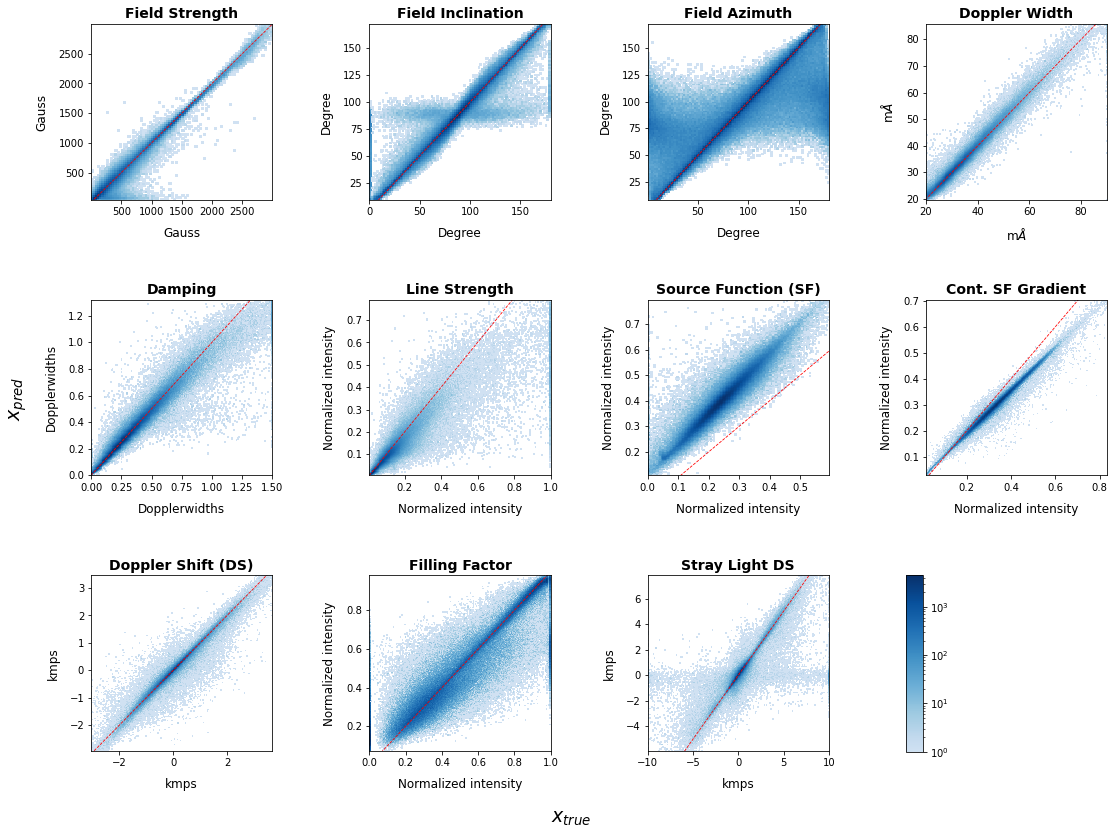

In [60]:
from inverse_problem.nn_inversion.posthoc import plot_correlation
plot_correlation(true, predicted_mean_norm[0], names, save_path=save_path, title='params')

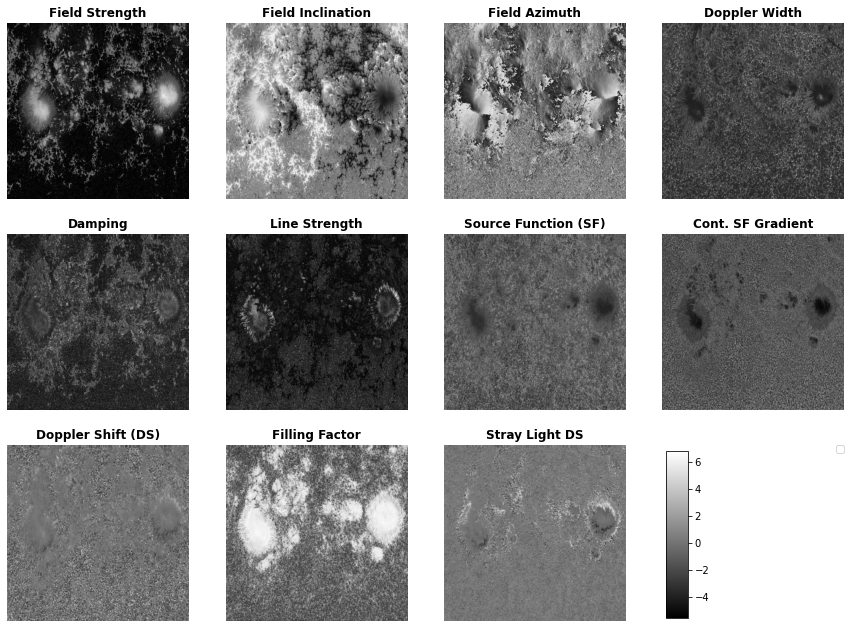

In [43]:
plot_params2(predicted_mean_norm[0].reshape(data.shape), save_path=save_path, title='refer_one_model')

In [28]:
predicted_mean_overall = np.mean(predicted_mean, axis = 0)
predicted_sigma_overall  = np.sqrt(np.mean(np.square(predicted_sigma) + np.square(predicted_mean), axis = 0) - np.square(predicted_mean_overall))

In [392]:
df_sim = compute_metrics(masked_ref_2d, predicted_mean_overall,
                sigmas=predicted_sigma_overall,
                save_path=save_path + 'metrics_ens.csv',
                mask=masked_ref_2d.mask)
df_sim.round(4)

,r2,mse,mae,nlpd,nrmse,picp68,picp95
Field Strength,0.9574,0.0007,0.0153,-2.9525,1.0055,0.6920,0.9566
Field Inclination,0.9858,0.0010,0.0174,-2.7402,1.0024,0.7060,0.9586
Field Azimuth,0.8322,0.0188,0.0637,-2.0132,0.9254,0.7524,0.9649
Doppler Width,0.9759,0.0004,0.0137,-2.7643,1.0089,0.6830,0.9525
Damping,0.9671,0.0005,0.0141,-2.8199,1.0097,0.6874,0.9512
Line Strength,0.8737,0.0009,0.0141,-3.0031,1.0380,0.7080,0.9479
S_0,0.9114,0.0004,0.0128,-2.8345,0.9647,0.7059,0.9617
S_1,0.9825,0.0001,0.0083,-3.2653,0.9535,0.7101,0.9642
Doppler Shift,0.9698,0.0000,0.0038,-4.3049,0.9591,0.7102,0.9619
Filling Factor,0.8819,0.0068,0.0541,-1.5641,0.9892,0.6916,0.9585


In [30]:
predicted_mean_norm_overall, predicted_sigma_norm_overall = inverse_transformation_unc(predicted_mean_overall, predicted_sigma_overall)

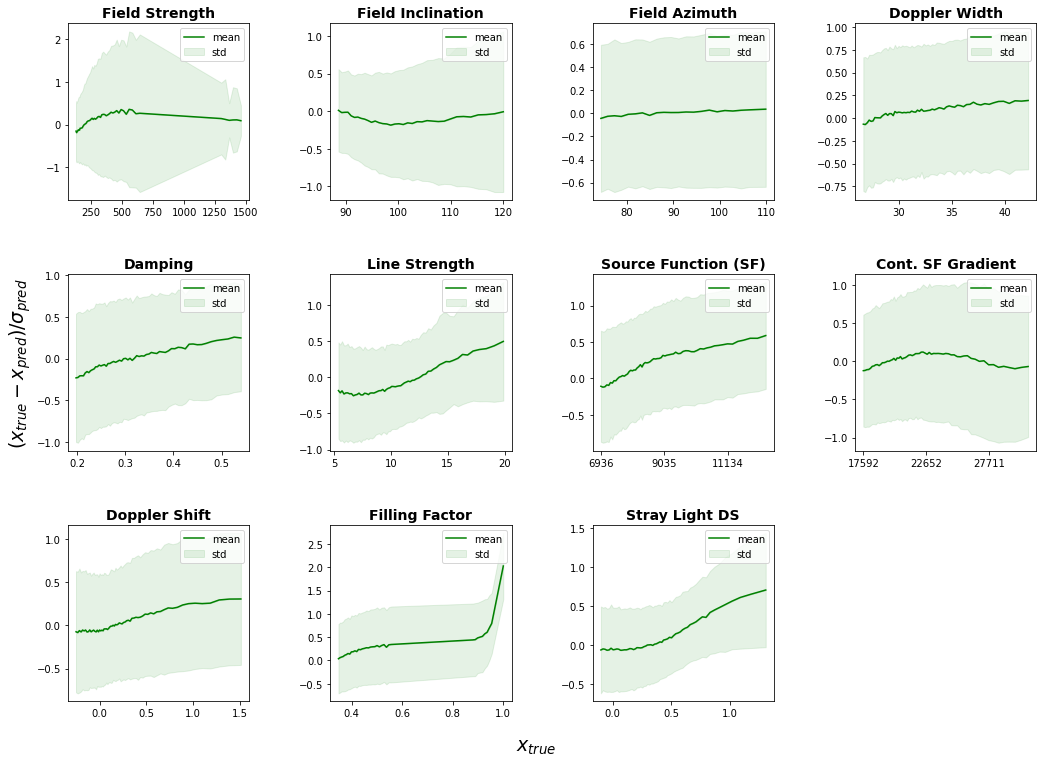

In [31]:
plot_fitting_curves_unc(true, predicted_mean_norm_overall, predicted_sigma_norm_overall, save_path=save_path, title='refer_ens')

In [50]:
def normalizeData(d):
    max_elem, min_elem = np.max(d), np.min(d)
    return (d - min_elem)/(max_elem-min_elem)

In [52]:
params_data = predicted_mean_norm.copy()
params_data[:, 5] = normalizeData(params_data[:, 5])
params_data[:, 6] = normalizeData(params_data[:, 6])
params_data[:, 7] = normalizeData(params_data[:, 7])

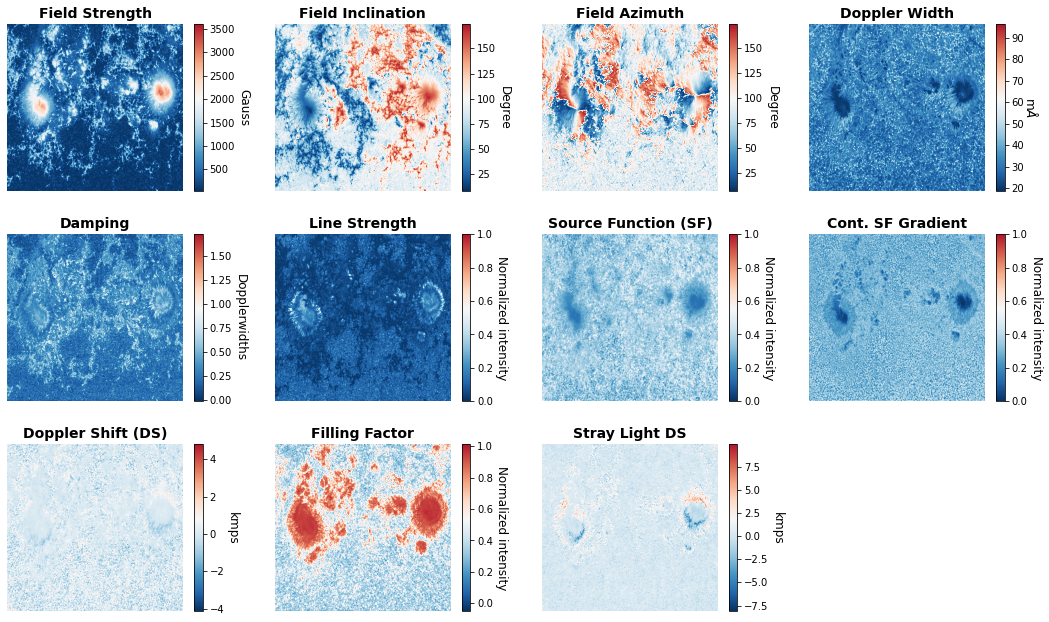

In [94]:
plot_params2(params_data.reshape(data.shape), names=names, save_path=save_path, title='RB', color_map='RdBu', inverse=True)